In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import os
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#=============================================
# データ読み込む
#=============================================
df = pd.read_csv("area_image.csv")

#=============================================
# 除外する閾値
#=============================================
threshold = 6 

#=============================================
# イメージのデータだけを抜き出す
#=============================================
# 抽出条件
target_keywords = ['ID', 'Car', 'image_']

# 上記キーワードを含む列名だけを抽出
selected_cols = [col for col in df.columns if any(keyword in col for keyword in target_keywords)]

# 条件に一致した列だけを含む新しいデータフレーム
df_traits = df[selected_cols]

df_traits.head(3)

,ID,Car,image_Elegant,image_Luxurious,image_Sporty,image_Technology,image_Futuristic,image_Traditional,image_Cute,image_Cool,image_Sleek
0,1,A車,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,2,A車,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,3,A車,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0


In [3]:
# ID と Car 列以外を対象のイメージ列として抽出
traits_cols = [col for col in df_traits.columns if col not in ["ID", "Car"]]

traits_to_keep_by_image = {}
df_filtered_by_image = {}

for car in df_traits["Car"].unique():
    # 車種ごとのデータを抽出
    df_image = df_traits[df_traits["Car"] == car]
    # イメージ列ごとに、選択数（値が1か-1の件数）をカウント
    counts = df_image[traits_cols].apply(lambda col: col.isin([1, -1]).sum())
    # 閾値以上のイメージだけを残す
    traits_to_keep = counts[counts >= threshold].index.tolist()
    traits_to_keep_by_image[car] = traits_to_keep
    # ID, Car列に加え、残したいイメージ列だけを抽出したデータフレームを保存
    df_filtered_by_image[car] = df_image[["ID", "Car"] + traits_to_keep]

# 全ての車種のデータを結合し、インデックスをリセット
df_all_image = pd.concat(df_filtered_by_image.values(), ignore_index=True)

# 列名から「image_」を削除
df_all_image.columns = df_all_image.columns.str.replace('image_', '', regex=True)
                                                       
# csv出力（必要に応じてコメント解除）
# df_all_image.to_csv("filtered_image.csv", index=False, encoding="utf-8-sig")

df_all_image.head(3)


,ID,Car,Elegant,Luxurious,Sporty,Technology,Futuristic,Cool,Sleek
0,1,A車,NaN,NaN,1.0,1.0,1.0,NaN,NaN
1,2,A車,NaN,NaN,1.0,1.0,1.0,NaN,NaN
2,3,A車,1.0,NaN,1.0,NaN,1.0,NaN,1.0


In [4]:
#=============================================
# パーツのデータだけを抜き出す
#=============================================
# 抽出条件
target_keywords = ['ID', 'Car', 'area_']

# 上記キーワードを含む列名だけを抽出したリスト
selected_cols = [col for col in df.columns if any(keyword in col for keyword in target_keywords)]
# 条件に合った列だけを含む新しいデータフレーム
df_parts = df[selected_cols]

df_parts.head(3)


,ID,Car,area_ボンネット,area_ホイール,area_アッパーグリル,area_リアグリル,area_バンパー,area_フェンダー,area_ドア,area_ヘッドライト
0,1,A車,NaN,1.0,-1.0,-1.0,1.0,NaN,NaN,NaN
1,2,A車,NaN,-1.0,NaN,NaN,1.0,NaN,NaN,-1.0
2,3,A車,NaN,1.0,1.0,-1.0,NaN,NaN,NaN,-1.0


In [5]:
#=============================================
# パーツの選択数〇件以下のパーツは除外
#=============================================
# ID と Car 列以外を対象のパーツ列として抽出
part_cols = [col for col in df_parts.columns if col not in ["ID", "Car"]]


parts_to_keep_by_car = {}
df_filtered_by_car = {}

for car in df_parts["Car"].unique():
    # 車種ごとのデータを抽出
    df_car = df_parts[df_parts["Car"] == car]
    # パーツ列ごとに、選択数（値が1か-1の件数）をカウント
    counts = df_car[part_cols].apply(lambda col: col.isin([1, -1]).sum())
    # 閾値以上のパーツだけを残す
    parts_to_keep = counts[counts >= threshold].index.tolist()
    parts_to_keep_by_car[car] = parts_to_keep
    # ID, Car列に加え、残したいパーツ列だけを抽出したデータフレームを保存
    df_filtered_by_car[car] = df_car[["ID", "Car"] + parts_to_keep]

# 全ての車種のデータを結合し、インデックスをリセット
df_all = pd.concat(df_filtered_by_car.values(), ignore_index=True)

# パーツ列名から「area_」を削除
df_all.columns = df_all.columns.str.replace('area_', '', regex=True)
# csv出力（必要に応じてコメント解除）
# df_all.to_csv("filtered_all_cars.csv", index=False, encoding="utf-8-sig")

df_all.head(3)


,ID,Car,ホイール,アッパーグリル,リアグリル,バンパー,ヘッドライト
0,1,A車,1.0,-1.0,-1.0,1.0,NaN
1,2,A車,-1.0,NaN,NaN,1.0,-1.0
2,3,A車,1.0,1.0,-1.0,NaN,-1.0


In [6]:
# 目的変数（y）
trait_cols = [c for c in df_all_image.columns if c not in ["ID", "Car"]]
# 説明変数（X）
area_cols = [c for c in df_all.columns if c not in ["ID", "Car"]]

# データ結合（ここはpartsではなくfilteredパーツデータで結合に注意）
df = pd.merge(df_all_image, df_all, on=["ID", "Car"])
# csv出力
df.to_csv("分析条件を満たしたデータ.csv", index=False, encoding="utf-8-sig")

df.head(3)


,ID,Car,Elegant,Luxurious,Sporty,Technology,Futuristic,Cool,Sleek,ホイール,アッパーグリル,リアグリル,バンパー,ヘッドライト
0,1,A車,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,-1.0,-1.0,1.0,NaN
1,2,A車,NaN,NaN,1.0,1.0,1.0,NaN,NaN,-1.0,NaN,NaN,1.0,-1.0
2,3,A車,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,-1.0,NaN,-1.0


In [7]:
# 出力用リストを準備
all_results = []
all_pvalues = []

for car in df['Car'].unique():
    # ① 車種ごとにデータを抽出
    df_car = df[df['Car'] == car]
    
    # ② 結果格納用の空DataFrameとカウント辞書を準備
    trait_result = pd.DataFrame(index=trait_cols, columns=area_cols)
    trait_pvalues = pd.DataFrame(index=trait_cols, columns=area_cols)
    counts = {}

    for trait in trait_cols:
        # ③ 各特性（trait）についてループ処理
        y = df_car[trait].fillna(0)
        X = df_car[area_cols].fillna(0)
        
        # ④ 目的変数の有効件数をカウント
        counts[trait] = (y != 0).sum()
        
        # ⑤ 目的変数が一定なら回帰をスキップ
        if y.nunique() <= 1:
            trait_result.loc[trait] = [0] * len(area_cols)
            trait_pvalues.loc[trait] = [np.nan] * len(area_cols)
            continue
            
        # ⑥ 説明変数の標準化とOLS回帰の実施
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 定数項を加えてOLS回帰モデルを作成し学習
        X_sm = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_sm)
        results_sm = model.fit()
        
        # 回帰係数とp値を取得（定数項は除外）
        coefs = results_sm.params[1:]
        pvals = results_sm.pvalues[1:]

        # 回帰係数とp値を小数点第3位で丸めて、見やすくしています
        trait_result.loc[trait] = np.round(coefs.values, 3)
        trait_pvalues.loc[trait] = np.round(pvals.values, 3)

    # Count列を左端に追加
    trait_result.insert(0, "Count", pd.Series(counts))
    trait_pvalues.insert(0, "Count", pd.Series(counts))

    # Countの降順で並べ替え
    trait_result = trait_result.sort_values(by="Count", ascending=False)
    trait_pvalues = trait_pvalues.loc[trait_result.index]

    # 車種名を示すCar列を追加
    trait_result["Car"] = car
    trait_pvalues["Car"] = car

    # インデックスをリセットしTrait列として追加
    trait_result = trait_result.reset_index().rename(columns={"index": "Trait"})
    trait_pvalues = trait_pvalues.reset_index().rename(columns={"index": "Trait"})

    # 結果リストに追加
    all_results.append(trait_result)
    all_pvalues.append(trait_pvalues)

# 全車種の結果を1つのDataFrameにまとめる
final_result = pd.concat(all_results, ignore_index=True)
final_pvalues = pd.concat(all_pvalues, ignore_index=True)

# Car列を先頭に移動
cols = ['Car'] + [col for col in final_result.columns if col != 'Car']
final_result = final_result[cols]

# 同様に p値の方も
cols_p = ['Car'] + [col for col in final_pvalues.columns if col != 'Car']
final_pvalues = final_pvalues[cols_p]


In [8]:
#=====================================
# CSV出力
#=====================================
final_result.to_csv("線形回帰.csv", index=False, encoding="utf-8-sig")
final_pvalues.to_csv("p値.csv", index=False, encoding="utf-8-sig")

current_dpath = os.getcwd()
os.startfile(current_dpath)



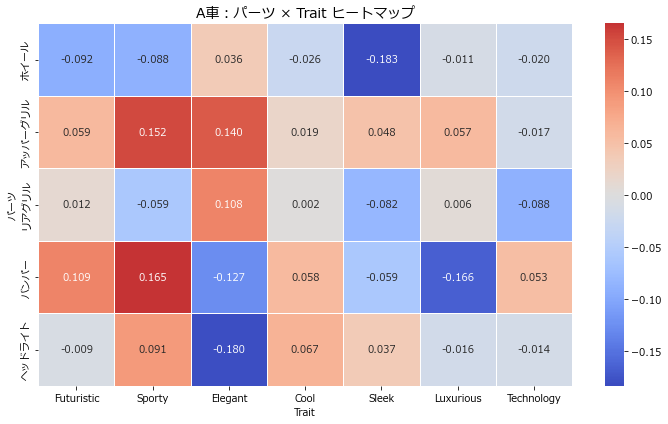

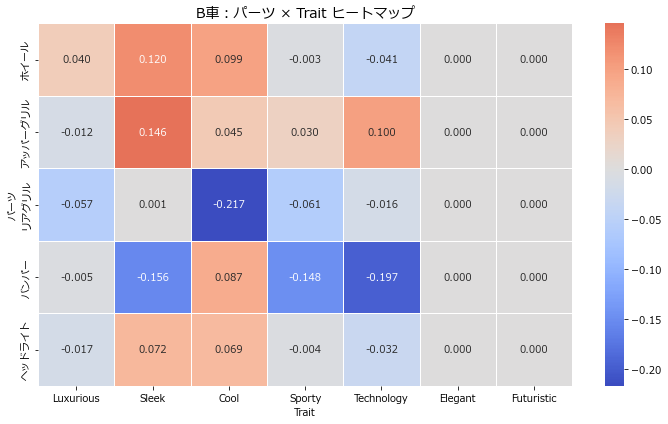

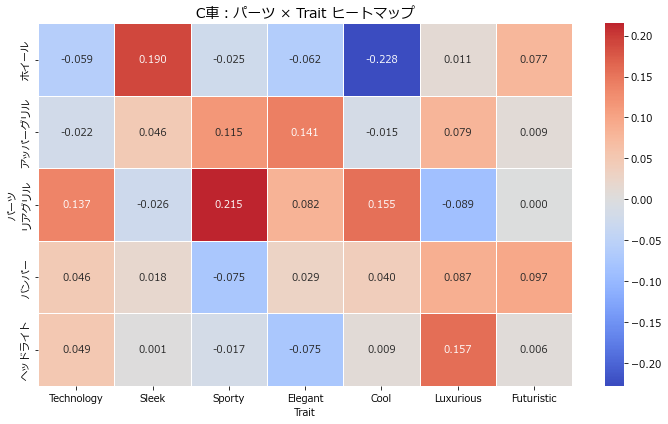

In [12]:

# 車種ごとにループ処理
cars = final_result["Car"].unique()

# フォント設定（日本語対策）
plt.rcParams['font.family'] = 'Meiryo'  # Windows用。Macの方は 'IPAexGothic' などに変更してください

# 回帰係数以外の列を除外
exclude_cols = ["Car", "Trait", "Count"]

for car in cars:
    # 該当車種のデータを抽出
    df_car = final_result[final_result["Car"] == car].copy()

    # Traitをインデックスにし、部品を行方向に並べ替え
    df_pivot = df_car.set_index("Trait").drop(columns=exclude_cols, errors="ignore").T

    # 数値データとして明示的に変換
    df_pivot = df_pivot.astype(float)

    # ヒートマップ描画
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_pivot, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".3f")
    plt.title(f"{car}：パーツ × Trait ヒートマップ", fontsize=14)
    plt.xlabel("Trait")
    plt.ylabel("パーツ")
    plt.tight_layout()
    plt.show()




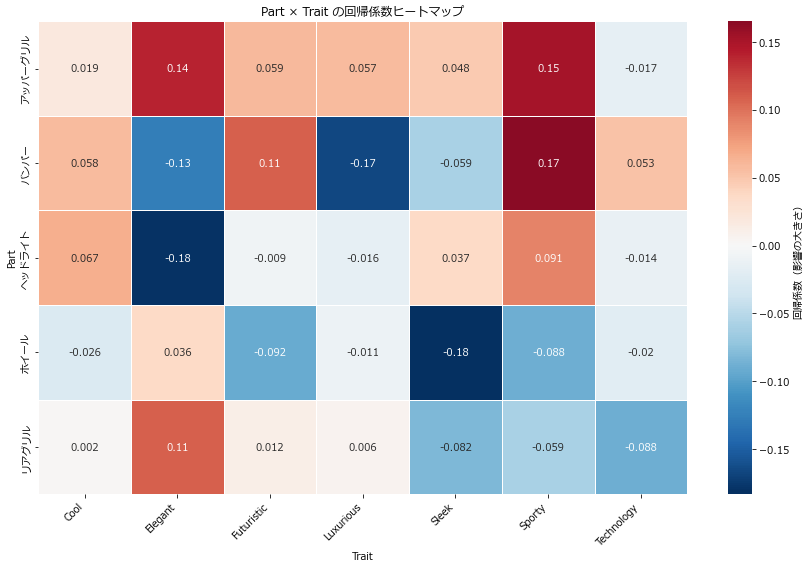

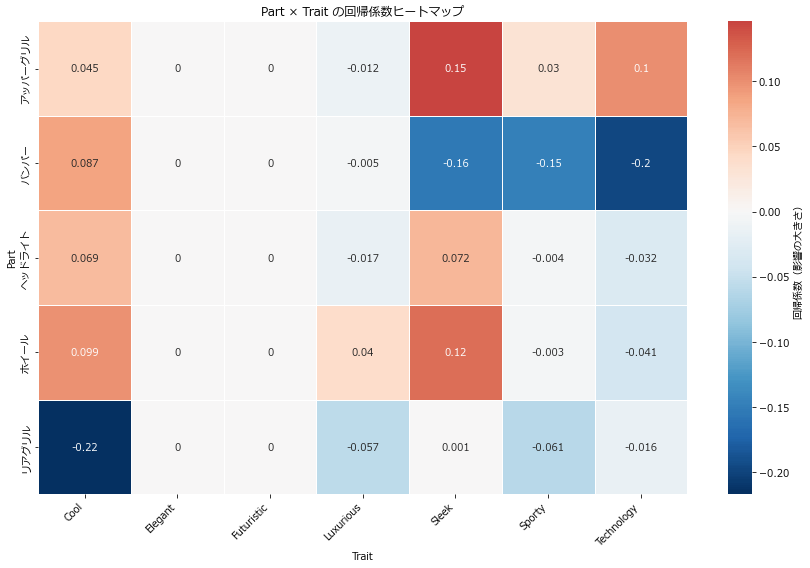

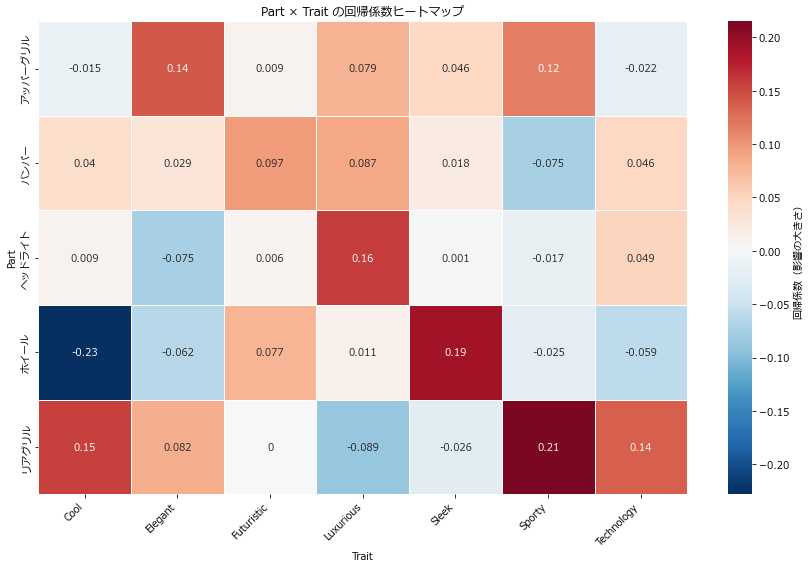

In [13]:

# 自動でプロット対象の列（パーツ名）を取得
cars = final_result['Car'].unique()

exclude_cols = ['Car', 'Trait', 'Count']
columns_to_plot = [col for col in final_result.columns if col not in exclude_cols]


for car in cars:
    # ① データ抽出：回帰係数とP値
    coefs = final_result[final_result['Car'] == car].set_index('Trait')[columns_to_plot]
    pvals = final_pvalues[final_pvalues['Car'] == car].set_index('Trait')[columns_to_plot]

    # ② P値の変換（logP）
    pvals = pvals.apply(pd.to_numeric, errors='coerce')    
    log_pvals = -np.log10(pvals.clip(lower=1e-10)) # log(0)回避
    
    # Trait×Partごとの回帰係数とP値を結合するための整形処理
    df_plot = coefs.reset_index().melt(id_vars='Trait', var_name='Part', value_name='Coef')
    df_logp = log_pvals.reset_index().melt(id_vars='Trait', var_name='Part', value_name='logP')
    df_merge = pd.merge(df_plot, df_logp, on=['Trait', 'Part'])
    df_merge['Label'] = df_merge['Trait'] + " × " + df_merge['Part']

    # ③ ヒートマップ用の行列に変換（pivot）
    pivot_table = df_merge.pivot(index='Part', columns='Trait', values='Coef')
    pivot_table = pivot_table.apply(pd.to_numeric, errors='coerce')
        
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot_table, annot=True, cmap="RdBu_r", center=0,linewidths=0.5,
                cbar_kws={'label': '回帰係数（影響の大きさ）'})
                
    plt.title("Part × Trait の回帰係数ヒートマップ")
    plt.ylabel("Part")
    plt.xlabel("Trait")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


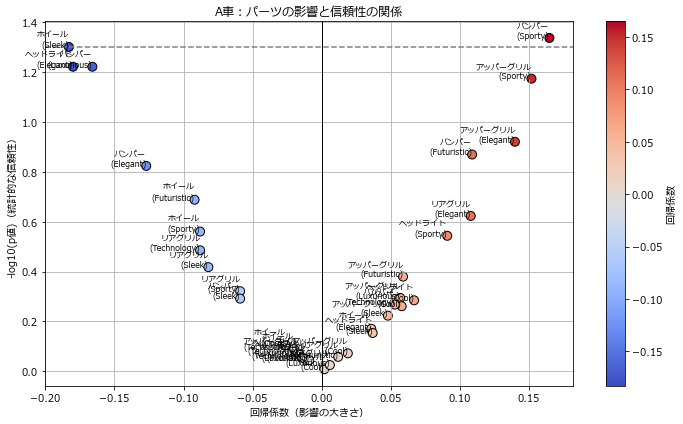

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


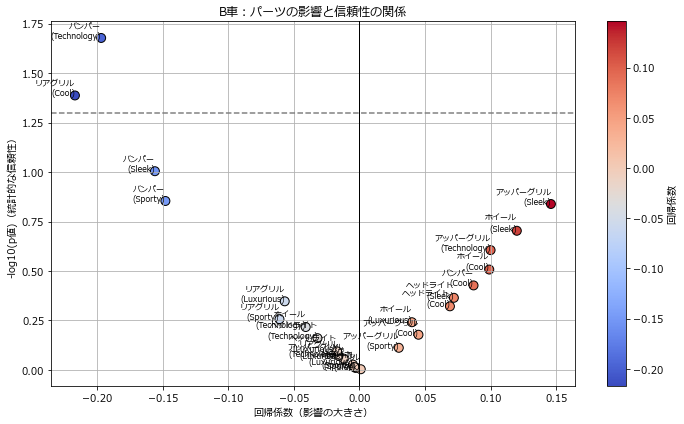

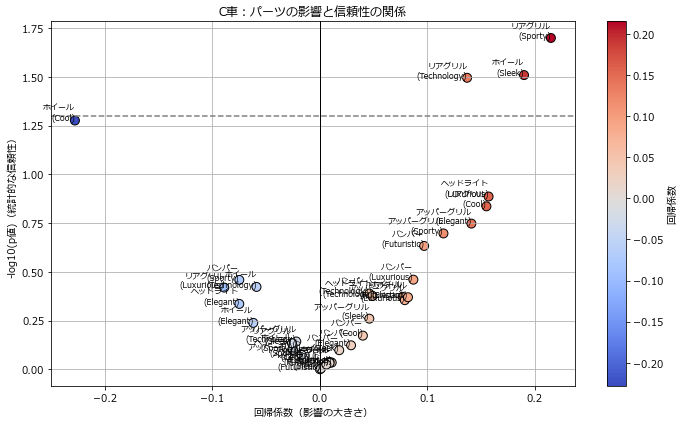

In [15]:
# 必要な列だけ抽出（例："Car", "Trait", "ホイール", ...）
cols = ["Car", "Trait"] + [col for col in final_result.columns if col not in ["Car", "Trait", "Count"]]

# データを整形
df_coef = final_result[cols].melt(id_vars=["Car", "Trait"], var_name="Part", value_name="Coef")
df_pval = final_pvalues[cols].melt(id_vars=["Car", "Trait"], var_name="Part", value_name="Pval")

# マージ
df_merge = pd.merge(df_coef, df_pval, on=["Car", "Trait", "Part"])

# −log10(p値) を計算（log(0)回避）
#df_merge["logP"] = -np.log10(df_merge["Pval"].clip(lower=1e-10))

# まず Pval を float に変換
df_merge["Pval"] = pd.to_numeric(df_merge["Pval"], errors="coerce")

# その後、-log10(p値) を計算
df_merge["logP"] = -np.log10(df_merge["Pval"].clip(lower=1e-10))

# ---- グラフ描画（全体 or 車種ごと） ----
cars = df_merge["Car"].unique()
for car in cars:
    df_car = df_merge[df_merge["Car"] == car]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_car["Coef"], df_car["logP"], c=df_car["Coef"],
                          cmap="coolwarm", edgecolor="k", s=80)

    plt.axhline(-np.log10(0.05), color='gray', linestyle='--', label="p=0.05")
    plt.axvline(0, color='black', linewidth=1)

    plt.xlabel("回帰係数（影響の大きさ）")
    plt.ylabel("-log10(p値)（統計的な信頼性）")
    plt.title(f"{car}：パーツの影響と信頼性の関係")
    plt.colorbar(label="回帰係数")
    plt.grid(True)

    # 全点にラベル追加
    for _, row in df_car.iterrows():
        plt.text(row["Coef"], row["logP"], f'{row["Part"]}\n({row["Trait"]})',
                 fontsize=8, ha='right')

    plt.tight_layout()
    plt.show()

for car in cars:
    df_car = df_merge[df_merge["Car"] == car]
    df_car.to_csv(f"パーツの影響と信頼性の関係{car}.csv", index=False, encoding="utf-8-sig")



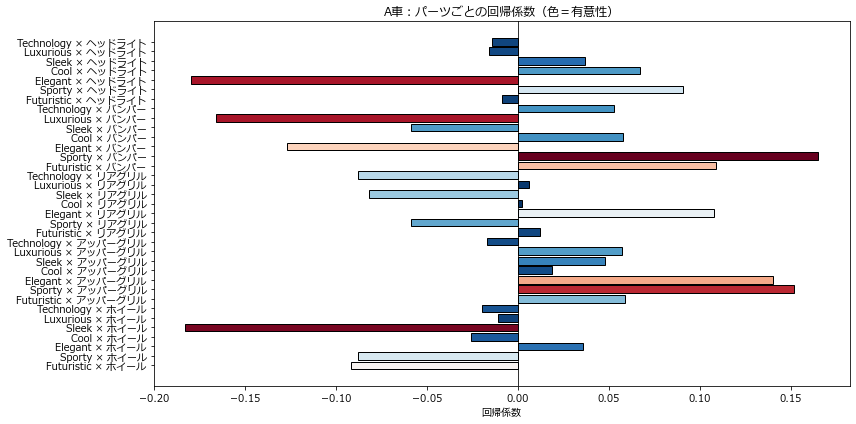

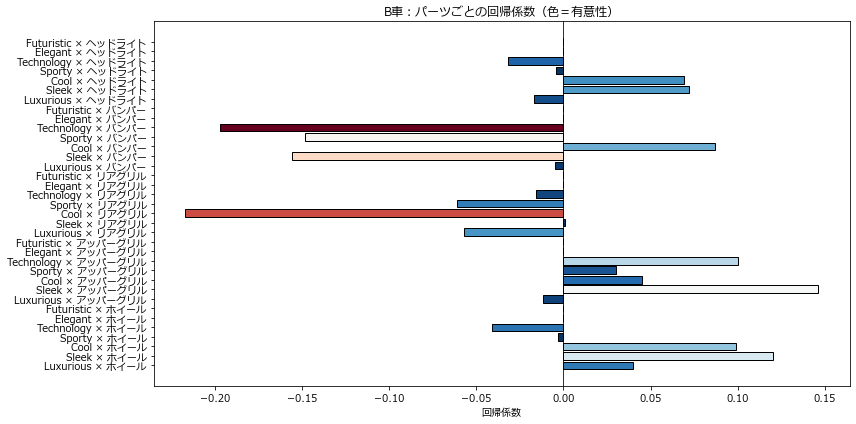

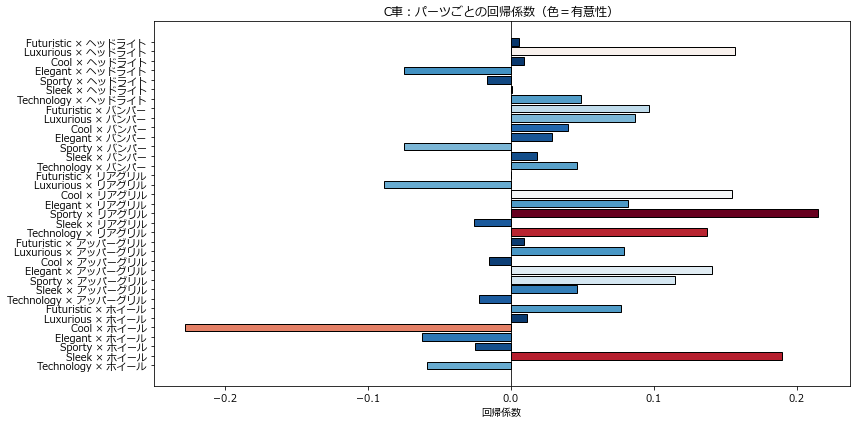

In [16]:
# 自動でプロット対象の列（パーツ名）を取得
columns_to_plot = [col for col in final_result.columns if col not in ['Car', 'Trait', 'Count']]

# 車種ごとに処理
for car in final_result['Car'].unique():
    # 対象車種の回帰係数とp値
    coefs = final_result[final_result['Car'] == car].set_index('Trait')[columns_to_plot]
    pvals = final_pvalues[final_pvalues['Car'] == car].set_index('Trait')[columns_to_plot]


    # 明示的に数値型に変換（非数値は NaN になる）
    pvals = pvals.apply(pd.to_numeric, errors='coerce')
    
    # クリップしてから log10 を取る（極端な小数値でinf対策）
    log_pvals = -np.log10(pvals.clip(lower=1e-10))    

    # -log10(P値) の計算（極小値にクリップしてinf回避）
    #log_pvals = -np.log10(pvals.clip(lower=1e-10))

    # Trait × Part で1列に整形
    df_plot = coefs.reset_index().melt(id_vars='Trait', var_name='Part', value_name='Coef')
    df_logp = log_pvals.reset_index().melt(id_vars='Trait', var_name='Part', value_name='logP')

    # 結合
    df_merge = pd.merge(df_plot, df_logp, on=['Trait', 'Part'])

    # パーツとイメージ名をY軸に連結して見やすく
    df_merge['Label'] = df_merge['Trait'] + " × " + df_merge['Part']

    # CSV出力（ファイル名に車種名を入れる）
    df_merge.to_csv(f"パーツごとの回帰係数_{car}.csv", index=False, encoding="utf-8-sig")    

    # 棒グラフ＋色で有意性（logP）を表現
    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        y=df_merge['Label'],
        width=df_merge['Coef'],
        color=plt.cm.RdBu_r((df_merge['logP'] / df_merge['logP'].max()).values),
        edgecolor='black'
    )
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title(f"{car}：パーツごとの回帰係数（色＝有意性）")
    plt.xlabel("回帰係数")
    plt.tight_layout()
    plt.show()

